## Part I: Preparing Data

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
DATA_PATH = "/content/drive/MyDrive/coronavirus-source-data/owid-covid-data.csv"

data_pd = pd.read_csv(DATA_PATH)

Выберем из таблицы данные по России, начиная с `3 марта 2020 г.` (в этот момент впервые стало больше 2 заболевших).

In [3]:
data_pd["date"] =  pd.to_datetime(data_pd["date"]).dt.normalize()

In [4]:
data_pd["date"]

0        2020-02-24
1        2020-02-25
2        2020-02-26
3        2020-02-27
4        2020-02-28
            ...    
166549   2022-03-02
166550   2022-03-03
166551   2022-03-04
166552   2022-03-05
166553   2022-03-06
Name: date, Length: 166554, dtype: datetime64[ns]

In [5]:
rus_march_mask = (
    (data_pd["date"] >= "2020-03-03") & 
    (data_pd["location"] == "Russia")
)
data_pd = data_pd[rus_march_mask].reset_index()

Даны данные за 734 дня

In [6]:
data_pd['date'].nunique()

734

In [7]:
data_pd.shape

(734, 68)

In [8]:
data_pd.sample(3)

,index,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
431,124386,RUS,Europe,Russia,2021-05-08,4816331.0,8198.0,8061.286,111097.0,362.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
105,124060,RUS,Europe,Russia,2020-06-16,544725.0,8241.0,8585.000,7274.0,193.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN
666,124621,RUS,Europe,Russia,2021-12-29,10279009.0,20957.0,23432.286,300886.0,903.0,...,23.4,58.3,NaN,8.05,72.58,0.824,NaN,NaN,NaN,NaN


In [9]:
data_pd.loc[(data_pd.new_cases == 0), "new_cases"] = 1

### Training & testing samples

Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта. Остальные данные используем в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [10]:
train_date_begin = data_pd["date"].min().normalize()
train_date_end = train_date_begin + pd.DateOffset(days=49)
test_date_begin = train_date_end + pd.DateOffset(days=1)
test_date_end = data_pd["date"].max().normalize()

print("train_date_begin:", train_date_begin)
print("train_date_end", train_date_end)

print("test_date_begin:", test_date_begin)
print("test_date_end", test_date_end)

train_date_begin: 2020-03-03 00:00:00
train_date_end 2020-04-21 00:00:00
test_date_begin: 2020-04-22 00:00:00
test_date_end 2022-03-06 00:00:00


In [11]:
def train_test_split(feature_matrix, target, 
                     train_date_begin, train_date_end,
                     test_date_begin, test_date_end):
    "The date column must be set to index."
    train_X = feature_matrix.loc[train_date_begin:train_date_end]
    test_X = feature_matrix.loc[test_date_begin:test_date_end]
    train_y = target.loc[train_date_begin:train_date_end]
    test_y = target.loc[test_date_begin:test_date_end]
    return train_X, test_X, train_y, test_y

In [12]:
data_pd = data_pd.set_index("date")

In [13]:
train_X, test_X, train_y, test_y = train_test_split(
    data_pd.drop(["total_cases", "new_cases"], axis=1),
    data_pd.loc[:, ["total_cases", "new_cases"]],
    train_date_begin, train_date_end,  
    test_date_begin, test_date_end
)

In [14]:
print(
    f"""
    Размеры выборок, (объекты, признаки).
    - Обучающая: {train_X.shape}
    - Тестовая: {test_X.shape}
    """
)


    Размеры выборок, (объекты, признаки).
    - Обучающая: (50, 65)
    - Тестовая: (684, 65)
    


## Part II: Exponential Linear Regression

Построим графики целевых переменных

In [15]:
def plot_target_distributions(fig, ax, data, target_names, 
                              titles, colors, suptitle, 
                              xlabel, ylabel):
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)
    if len(target_names) == 1:
        ax = [ax]

    for i, target_name in enumerate(target_names):
        ax[i].set_title(f"{target_name}", fontsize=22, pad=10)
        ax[i].set_xlabel(xlabel, fontsize=22, labelpad=10)
        ax[i].set_ylabel(ylabel, fontsize=22, labelpad=10)
        ax[i].ticklabel_format(style='sci', axis='y')
    ax[0].yaxis.set_label_position("left")
    if len(target_names) > 1:
        ax[1].yaxis.set_label_position("right")
        ax[1].yaxis.tick_right()

    for i, target_name in enumerate(target_names):
        for sample_type in data.keys():
            ax[i].scatter(
                x=data[sample_type].index,
                y=data[sample_type].loc[:, target_name], 
                label=sample_type, 
                color=colors[sample_type], 
                edgecolor="gold", lw=0.2,
            )
            ax[i].plot(data[sample_type].index, data[sample_type].loc[:, target_name], 
                color=colors[sample_type], lw=0.5,
            )
        
        legend = ax[i].legend(framealpha=1)
        frame = legend.get_frame()
        frame.set_facecolor("white")
        frame.set_edgecolor("black")
        
        vals = ax[i].get_yticks()
        ax[i].set_yticklabels(["{:,.10}".format(x) for x in vals])
        ax[i].xaxis.set_tick_params(rotation=45)

    plt.show()

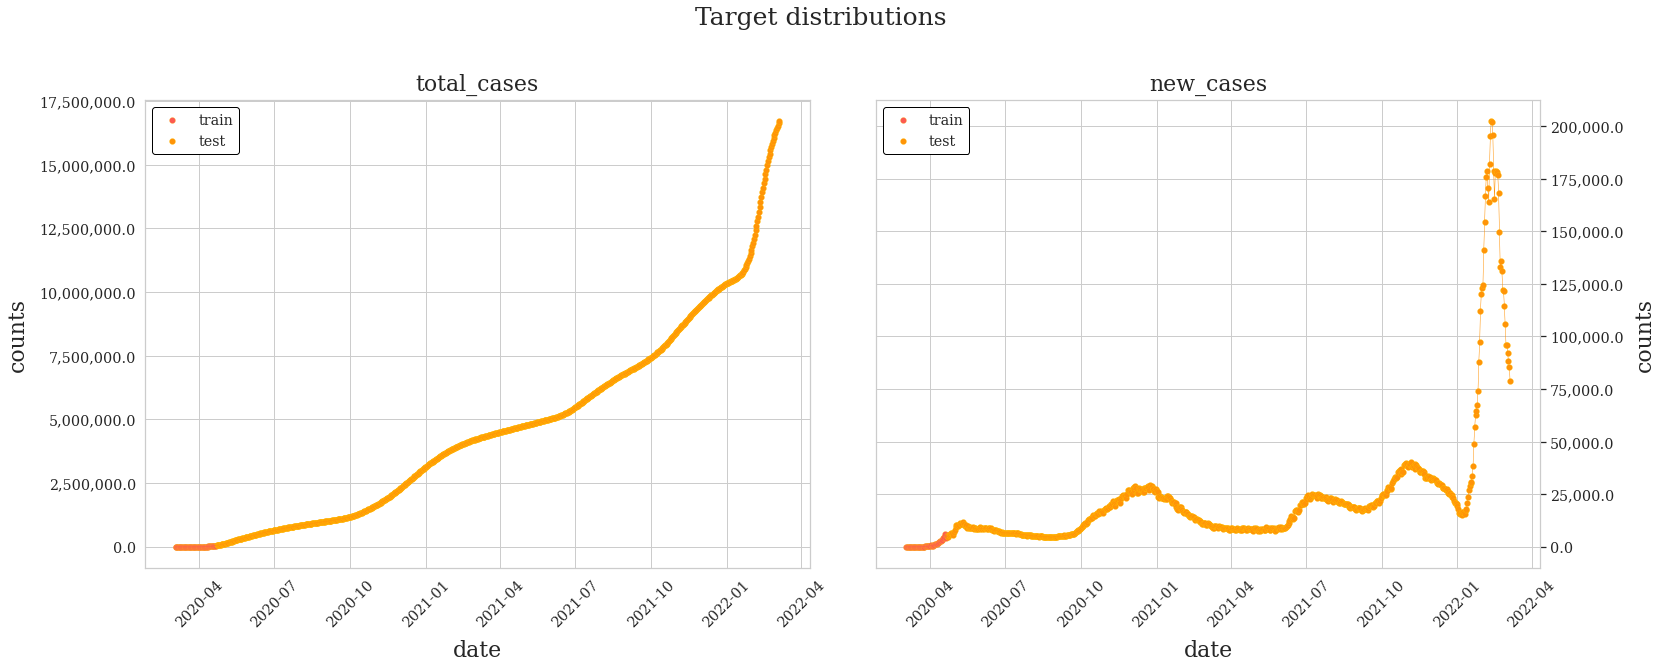

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
target_names = list(train_y.columns)

plot_target_distributions(fig, ax,
                          data={"train": train_y, 
                                "test": test_y},
                          target_names=target_names,
                          titles=["Total confirmed cases of COVID-19", 
                                  "New confirmed cases of COVID-19"],
                          colors={"train": "xkcd:coral",
                                  "test": "xkcd:tangerine"},
                          suptitle="Target distributions",
                          xlabel="date",
                          ylabel="counts")

Число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.


### 2.1 Linear Regression

Используя линейную регрессию, обучим модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [17]:
from sklearn.linear_model import LinearRegression

Пронумеруем наши дни (начиная с единицы)

In [18]:
test_X.shape[0]

684

In [19]:
train_day_nums = np.arange(0, train_X.shape[0]).reshape(-1, 1)
test_day_nums = np.arange(train_X.shape[0], train_X.shape[0] + test_X.shape[0]).reshape(-1, 1)

Логарифмируем целевые переменные

In [20]:
train_log_y = np.log(train_y)
test_log_y = np.log(test_y)

Обучим линейную регрессию

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(train_day_nums,
            np.array(train_log_y.total_cases.values).reshape(-1, 1))

LinearRegression()

In [22]:
pred_train_y_pd = pd.DataFrame()
pred_train_y_pd["total_cases"] = np.round(np.exp(lin_reg.predict(train_day_nums).flatten()))

pred_test_y_pd = pd.DataFrame()
pred_test_y_pd["total_cases"] = np.round(np.exp(lin_reg.predict(test_day_nums).flatten()))

In [23]:
pred_train_y_pd.index = train_y.index
pred_test_y_pd.index = test_y.index

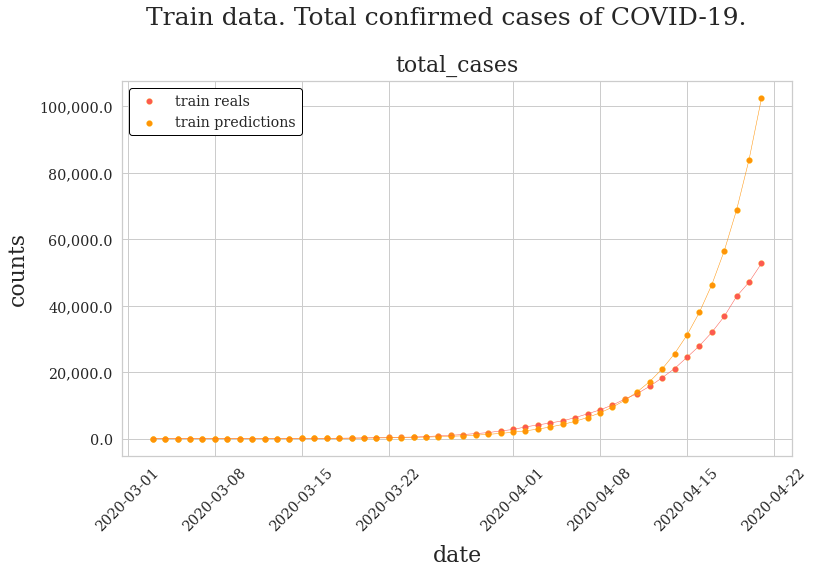

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_target_distributions(fig, ax,
                          data={"train reals": train_y, 
                                "train predictions": pred_train_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19"],
                          colors={"train reals": "xkcd:coral",
                                  "train predictions": "xkcd:tangerine"},
                          suptitle="Train data. Total confirmed cases of COVID-19.",
                          xlabel="date",
                          ylabel="counts")

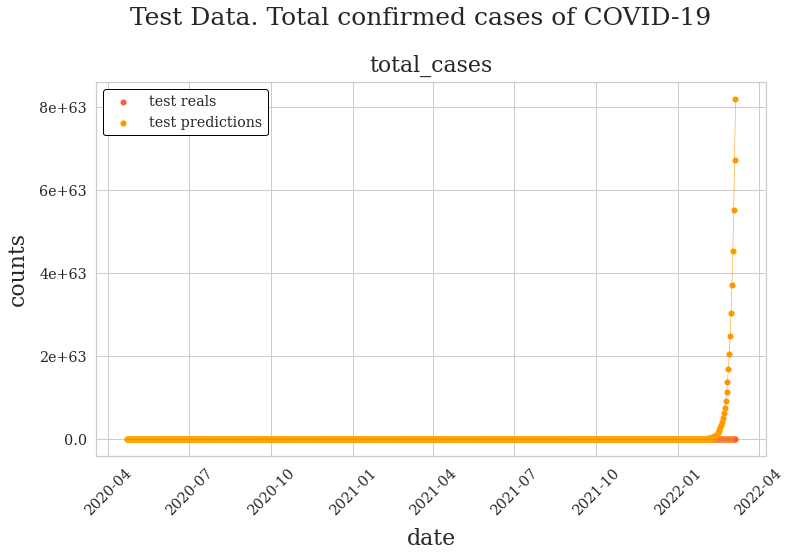

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_target_distributions(fig, ax,
                          data={"test reals": test_y, 
                                "test predictions": pred_test_y_pd},
                          target_names=["total_cases"],
                          titles=["Total confirmed cases of COVID-19 on Test Data"],
                          colors={"test reals": "xkcd:coral",
                                  "test predictions": "xkcd:tangerine"},
                          suptitle="Test Data. Total confirmed cases of COVID-19",
                          xlabel="date",
                          ylabel="counts")

### 2.2 Posterior parameters distributions

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [26]:
class GaussianDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def __str__(self):
        s = f"""Gaussian: \nmean={self.mean} \ncov=\n{self.cov}
        """
        return s

В качестве априорного выберем нормальное с нулевым средним и диаогональной ковариационной матрицей

In [27]:
inv_alpha = 1e4
prior_distribution = GaussianDistribution(mean=np.zeros(2), 
                                          cov=np.eye(2)*inv_alpha)

In [28]:
print(prior_distribution)

Gaussian: 
mean=[0. 0.] 
cov=
[[10000.     0.]
 [    0. 10000.]]
        


Найдем апостериорное распределение (по формулам из лекции)

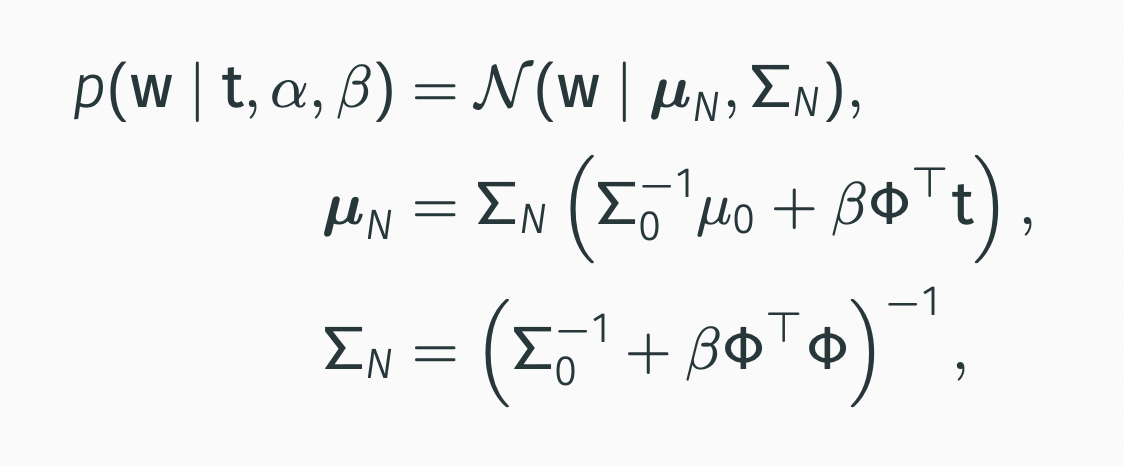

In [29]:
sigma_0_inv = np.linalg.inv(prior_distribution.cov)
mu_0 = prior_distribution.mean

variance = np.var(
    train_log_y.total_cases - np.log(pred_train_y_pd.total_cases),
    ddof=1
)
print(f"Variance: {variance:.4}")

Fi = np.hstack((
    np.ones(50).reshape(-1, 1),
    train_day_nums.reshape(-1, 1)
))
t = np.log(train_y.total_cases)

Variance: 0.1253


In [30]:
sigma_N = np.linalg.inv(sigma_0_inv + Fi.T @ Fi / variance)
mu_N = sigma_N @ (sigma_0_inv @ mu_0 + Fi.T @ t / variance)

In [31]:
posterior_distribution = GaussianDistribution(mean=mu_N, 
                                              cov=sigma_N)

In [32]:
print(posterior_distribution)

Gaussian: 
mean=[1.82073538 0.19829097] 
cov=
[[ 9.73210284e-03 -2.94912207e-04]
 [-2.94912207e-04  1.20372360e-05]]
        


### 2.3 Sampling of many different exponents

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

In [33]:
posterior_gen_w = np.random.multivariate_normal(
    posterior_distribution.mean, posterior_distribution.cov, 200
)
posterior_pred_y_train = np.exp(posterior_gen_w @ Fi.T)

In [34]:
posterior_pred_y_train.shape

(200, 50)

In [35]:
np.mean(posterior_pred_y_train, axis=0).shape

(50,)

In [36]:
def plot_posterior_sample_lines(fig, ax, real_total_case, 
                                sampling_posterior_preds, mean_posterior_preds,
                                colors, suptitle, x_ticks,
                                xlabel, ylabel):
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)

    ax.set_xlabel(xlabel, fontsize=22, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=22, labelpad=10)
    ax.ticklabel_format(style='sci', axis='y')
    ax.yaxis.set_label_position("left")

    ax.scatter(x=x_ticks, y=real_total_case.values,
               label="Reals", color=colors["Reals"], 
               marker="*", s=15**2, edgecolor="gold", lw=0.2)
    ax.plot(x_ticks, real_total_case.values, color=colors["Reals"])

    for y in posterior_pred_y_train:
        ax.plot(x_ticks, y, color=colors["Sampling"], lw=0.05)

    ax.scatter(x=x_ticks, y=mean_posterior_preds,
               label="Means", color=colors["Means"], 
               marker="o", s=8**2, edgecolor="gold", lw=0.2)
    ax.plot(x_ticks, mean_posterior_preds, color=colors["Means"])
        
    legend = ax.legend(framealpha=1)
    ax.legend(loc="upper left", fontsize=24)
    frame = legend.get_frame()
    frame.set_facecolor("white")
    frame.set_edgecolor("black")
        
    vals = ax.get_yticks()
    ax.set_yticklabels(["{:,}".format(x) for x in vals])
    ax.xaxis.set_tick_params(rotation=45)

    plt.show()

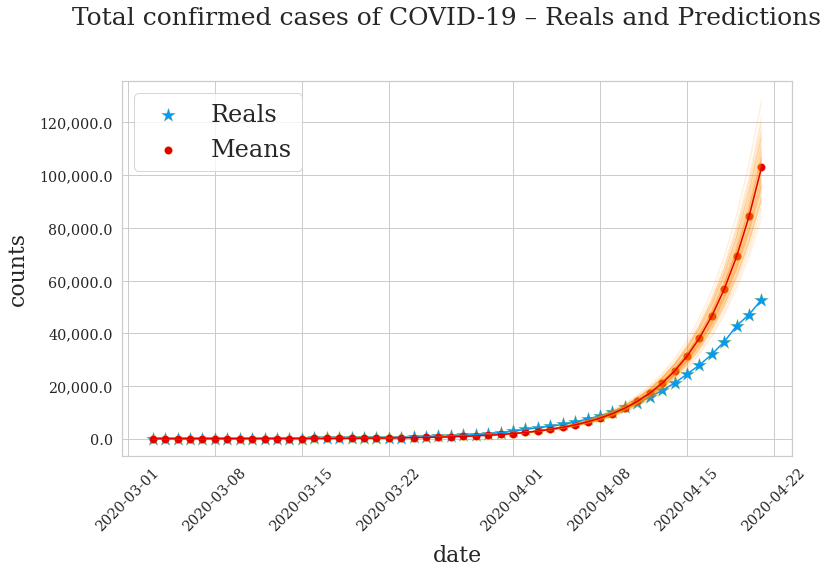

In [37]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plot_posterior_sample_lines(fig, ax,
                          real_total_case=train_y.total_cases,
                          sampling_posterior_preds=posterior_pred_y_train,
                          mean_posterior_preds=np.mean(posterior_pred_y_train, axis=0),
                          colors={"Reals": "xkcd:azure",
                                  "Sampling": "xkcd:tangerine",
                                  "Means": "xkcd:red"},
                          suptitle="Total confirmed cases of COVID-19 – Reals and Predictions",
                          x_ticks=train_y.total_cases.index,
                          xlabel="date",
                          ylabel="counts")

Предсказания случаев коронавируса в России к 1 мая, к 1 июня и к 1 сентября, исходя из сэмплов.

In [38]:
from datetime import datetime

In [39]:
first_may = (datetime(2020, 5, 1) - train_date_begin).days
first_june = (datetime(2020, 6, 1) - train_date_begin).days
first_sep = (datetime(2020, 9, 1) - train_date_begin).days
feature_one_day_matrix = np.array([
    np.ones(3),
    [first_may, first_june, first_sep]
])

In [40]:
posterior_gen_w.shape

(200, 2)

In [41]:
feature_one_day_matrix.shape

(2, 3)

In [42]:
one_day_target_predictions = np.exp(posterior_gen_w @ feature_one_day_matrix)

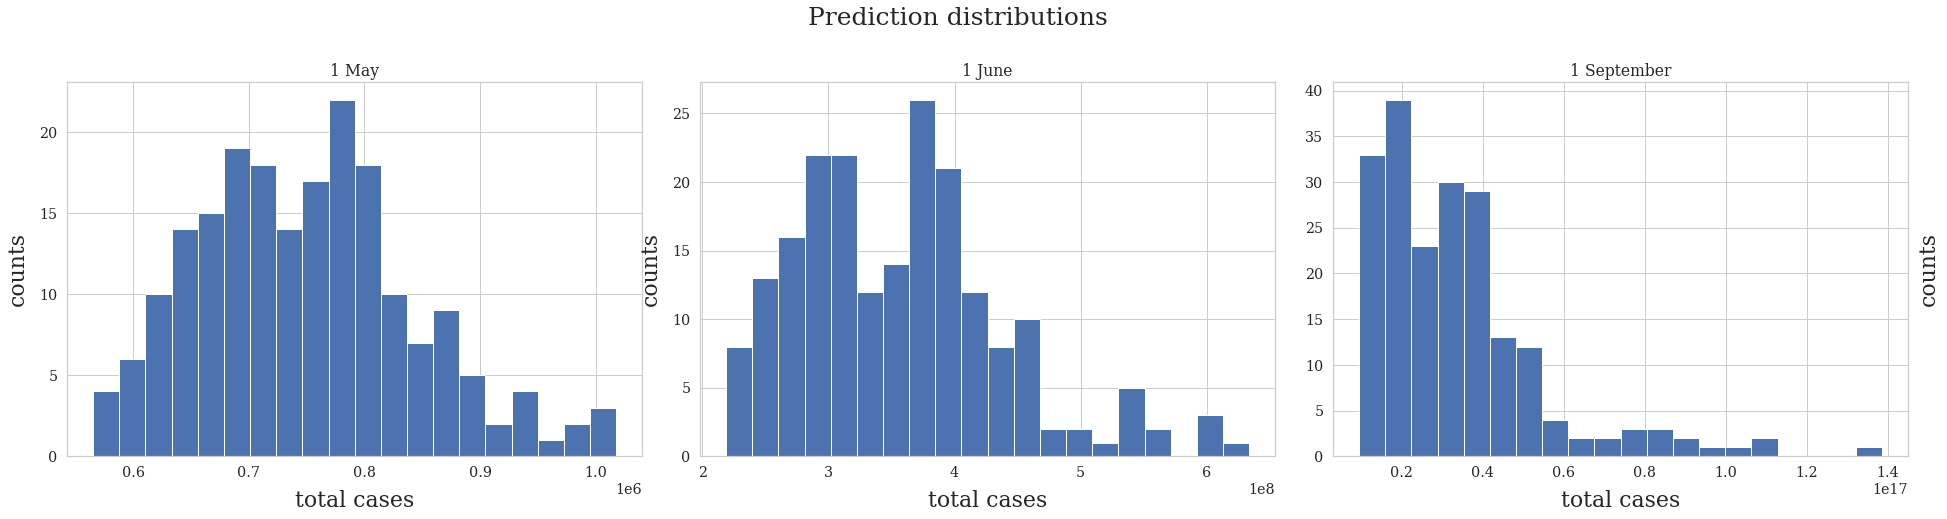

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(33, 8))
fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
fig.suptitle("Prediction distributions", fontsize=25)
fig.align_labels(axs=ax)

for i in range(3):
    ax[i].set_xlabel("total cases", fontsize=22, labelpad=10)
    ax[i].set_ylabel("counts", fontsize=22, labelpad=10)
    ax[i].grid("black")

ax[0].set_title("1 May")
ax[0].yaxis.set_label_position("left")
ax[0].hist(one_day_target_predictions[:, 0], bins=20)

ax[1].set_title("1 June")
ax[1].hist(one_day_target_predictions[:, 1], bins=20)

ax[2].set_title("1 September")
ax[2].yaxis.set_label_position("right")
ax[2].hist(one_day_target_predictions[:, 2], bins=20)

plt.show()